In [1]:
import os

import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import xarray as xr
import yaml

from src import data_catalog
from src.config import noaa_co2_flask_surface_dir, var_specs_fname
from src.utils_noaa_co2_flask_surface import co2_flask_surface_read_file
from src.esmlab_wrap import compute_ann_mean
from src.utils import time_year_plus_frac, print_timestamp
from src.utils_data_catalog import gen_ds_var
from src.utils_units import conv_units
%matplotlib inline

In [2]:
def dataset_summary(ds_list, legend_list=None):
    _, ax_mon_values = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    _, ax_ann_values = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    _, ax_mon_anomalies = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    _, ax_mon_anomaly_clim = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    _, ax_seas_cyc_amp = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    linestyle_list = [
        'solid',
        (0, (4, 1)),
        (0, (6, 2, 1, 2)),
        (0, (6, 3)),
    ]
    for ind, ds in enumerate(ds_list):
        time = time_year_plus_frac(ds, "time")
        print(f'samples = {len(time)}')
        year_min = np.floor(time.min())
        year_max = np.ceil(time.max())
        print(f'year_span = {year_min}-{year_max}' )
        print(f'samples per year = {len(time) / (year_max - year_min)}' )
        print('****************************************')

        label = legend_list[ind] if legend_list is not None else None

        Line2D_list = ds["CO2"].plot(ax=ax_mon_values, label=label, linewidth=2.0)
        Line2D_list[0].set_linestyle(linestyle_list[ind])

        ds_ann = compute_ann_mean(ds)
        Line2D_list = ds_ann["CO2"].plot(ax=ax_ann_values, label=label, linewidth=2.0)
        Line2D_list[0].set_linestyle(linestyle_list[ind])

        ds_trunc = ds.isel(time=slice(12,-12))
        ds_mon_anom = ds_trunc - ds_ann.interp(time=ds_trunc.time)
        Line2D_list = ds_mon_anom["CO2"].plot(ax=ax_mon_anomalies, label=label, linewidth=2.0)
        Line2D_list[0].set_linestyle(linestyle_list[ind])

        ds_mon_anom_slice = ds_mon_anom.sel(time=slice("1981-01-01", "2015-01-01"))
        ds_mon_anom_clim = ds_mon_anom_slice.groupby("time.month").mean("time", keep_attrs=True)
        Line2D_list = ds_mon_anom_clim["CO2"].plot(ax=ax_mon_anomaly_clim, label=label, linewidth=2.0)
        Line2D_list[0].set_linestyle(linestyle_list[ind])

        ds_year_max = ds_mon_anom.groupby("time.year").max("time", keep_attrs=True)
        ds_year_min = ds_mon_anom.groupby("time.year").min("time", keep_attrs=True)
        ds_seas_amp = ds_year_max - ds_year_min
        Line2D_list = ds_seas_amp["CO2"].plot(ax=ax_seas_cyc_amp, label=label, linewidth=2.0)
        Line2D_list[0].set_linestyle(linestyle_list[ind])

    for ax in [ax_mon_values, ax_ann_values, ax_mon_anomalies, ax_mon_anomaly_clim, ax_seas_cyc_amp]:
        if legend_list is not None:
            ax.legend(handlelength=6)
            ax.set_title(None)
    plt.show()

{'brw': {'year_span': (1972, 2019), 'lat': 71.32, 'lon': 203.4, 'press': 1000.0}, 'mlo': {'year_span': (1977, 2019), 'lat': 19.53, 'lon': 204.32, 'press': 680.0}}
slice('1972-01-01', '2019-01-01', None)
samples = 564
year_span = 1972.0-2019.0
samples per year = 12.0
****************************************


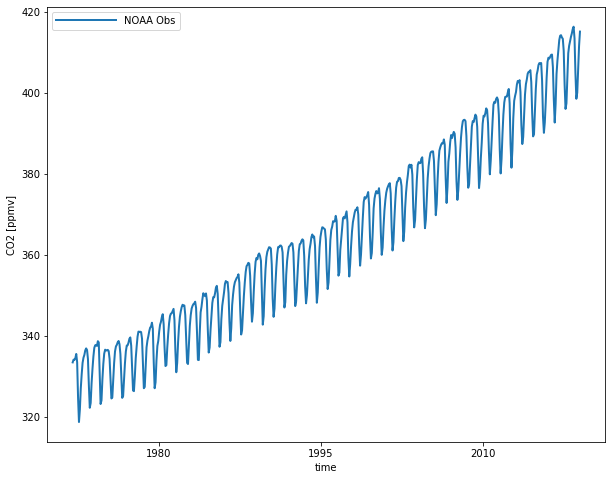

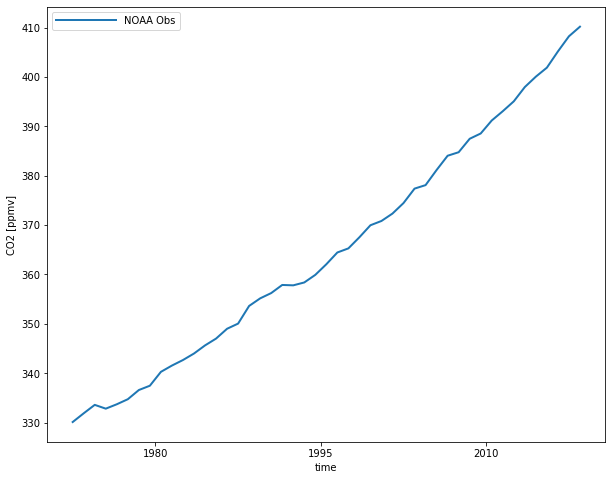

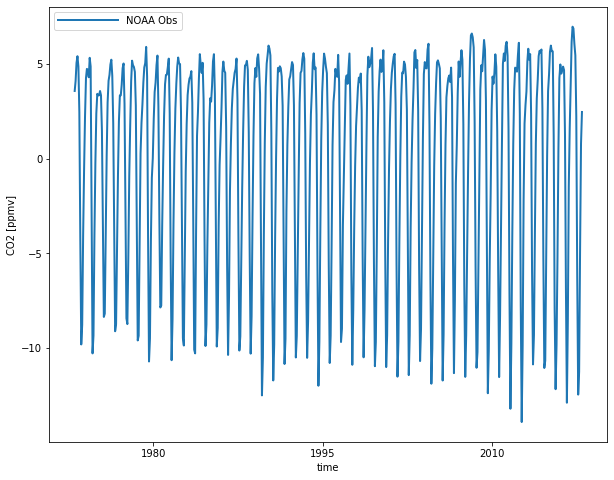

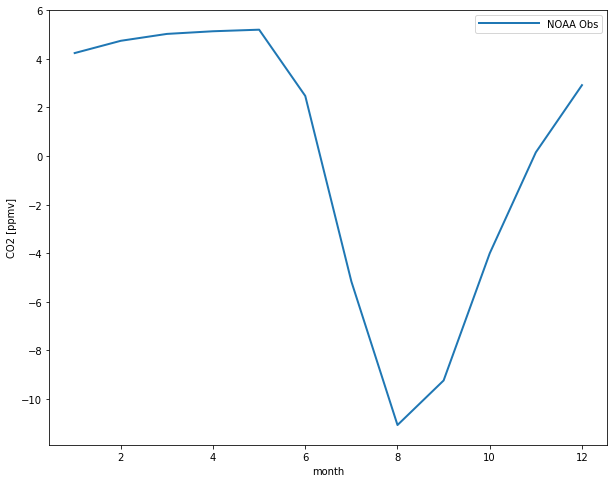

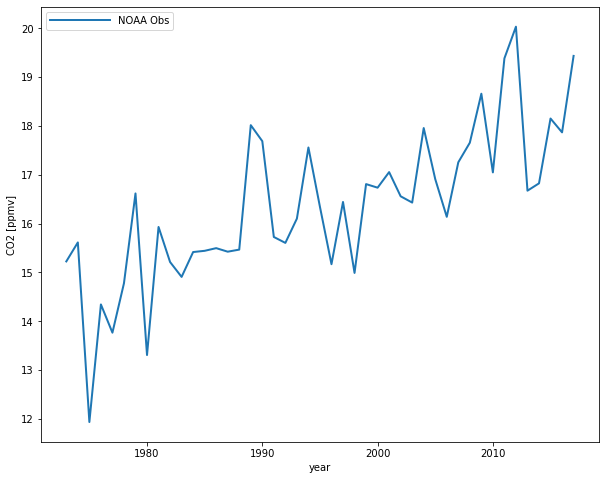

slice('1977-01-01', '2019-01-01', None)
samples = 504
year_span = 1977.0-2019.0
samples per year = 12.0
****************************************


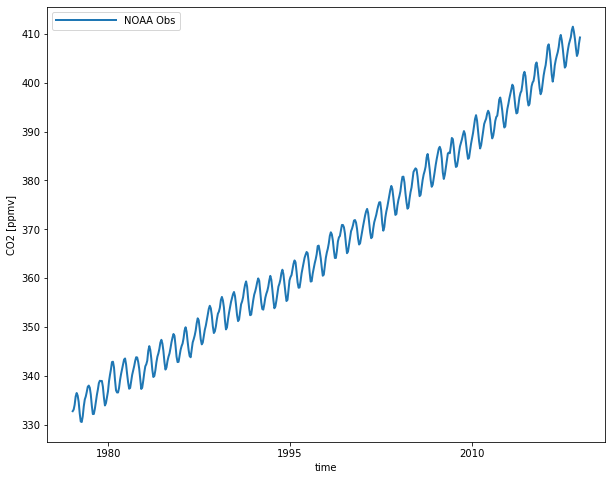

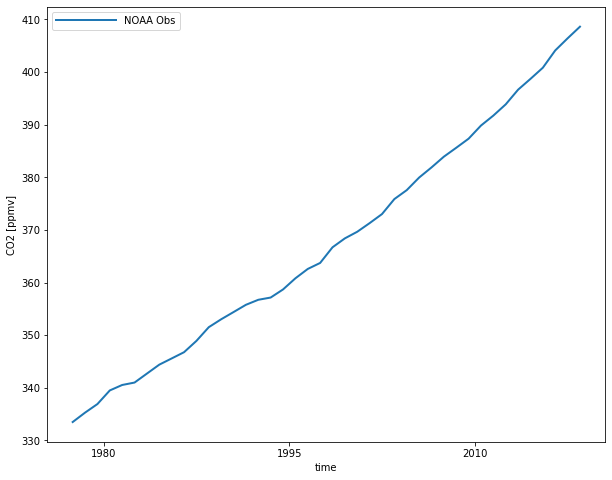

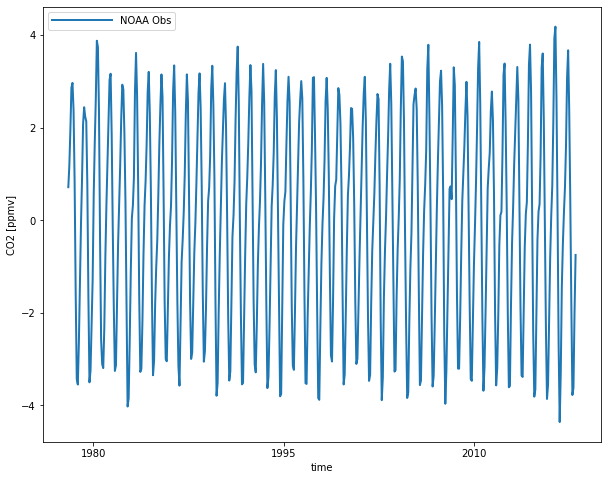

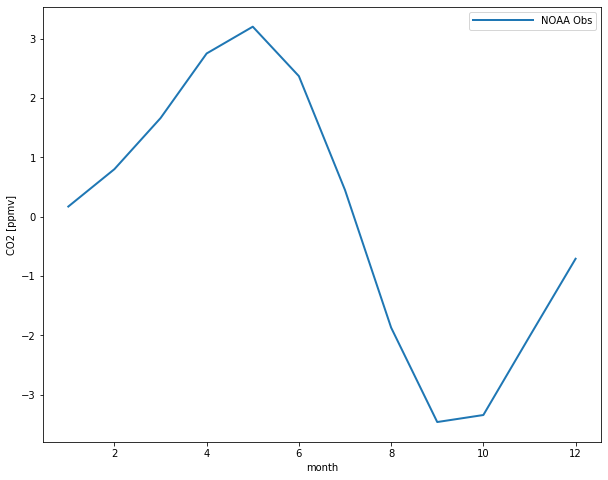

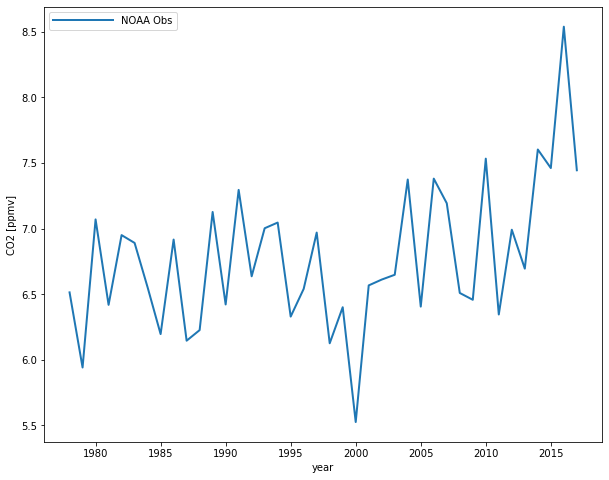

In [3]:
site_metadata_dict = {
    'brw': {"year_span": (1972, 2019), "lat": 71.32, "lon": (360-156.60), "press": 1000.0},
    'mlo': {"year_span": (1977, 2019), "lat": 19.53, "lon": (360-155.68), "press": 680.0},
}
print(site_metadata_dict)

ds_obs = {}
for site, site_metadata in site_metadata_dict.items():
    path = os.path.join(noaa_co2_flask_surface_dir, "surface", f"co2_{site}_surface-flask_1_ccgg_month.txt")
    year_span = site_metadata["year_span"]
    time_sel = slice(f"{year_span[0]:04d}-01-01", f"{year_span[1]:04d}-01-01")
    print(time_sel)
    ds_obs[site] = co2_flask_surface_read_file(path)[["time_bounds", "CO2"]].sel(time=time_sel)
    for key in ["lat", "lon"]:
        ds_obs[site].attrs[key] = site_metadata[key]
    dataset_summary([ds_obs[site]], legend_list=["NOAA Obs"])

In [4]:
data_catalog.set_catalog("cesm_coupled")
ds_dict = {}
varname = "CO2"
component = "atm"
for expr in ["esm-hist-cmip5", "esm-hist"]:
    stream = "cam.h0" if "cmip5" not in expr else "cam2.h0"
    ds_dict[expr] = gen_ds_var(varname, component, expr, stream)

with open(var_specs_fname, mode="r") as fptr:
    var_specs_all = yaml.safe_load(fptr)
var_spec = var_specs_all[component]["vars"][varname]

active catalog: cesm_coupled
2020-03-02 19:45:43.492274(gen_ds_var):entering gen_ds_var, varname=CO2, experiment=esm-hist-cmip5
2020-03-02 19:46:09.699552(gen_ds_var):entering gen_ds_var, varname=CO2, experiment=esm-hist


2020-03-02 19:46:12.598265(<module>):loading model output for esm-hist-cmip5 at brw
2020-03-02 19:46:31.454449(<module>):loaded
2020-03-02 19:46:31.479526(<module>):loading model output for esm-hist at brw
2020-03-02 19:47:50.230795(<module>):loaded
samples = 1032
year_span = 1920.0-2006.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 564
year_span = 1972.0-2019.0
samples per year = 12.0
****************************************


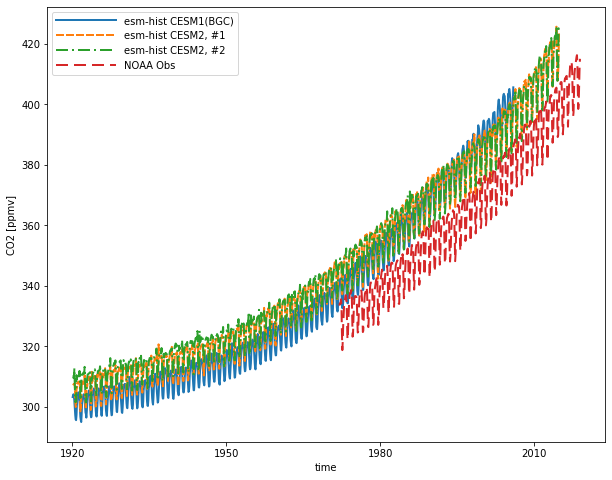

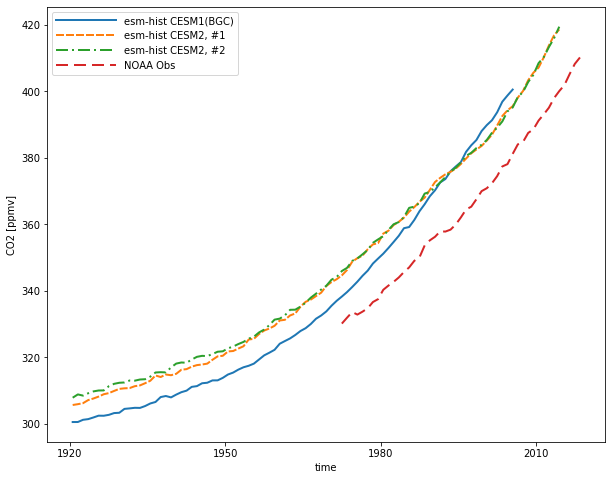

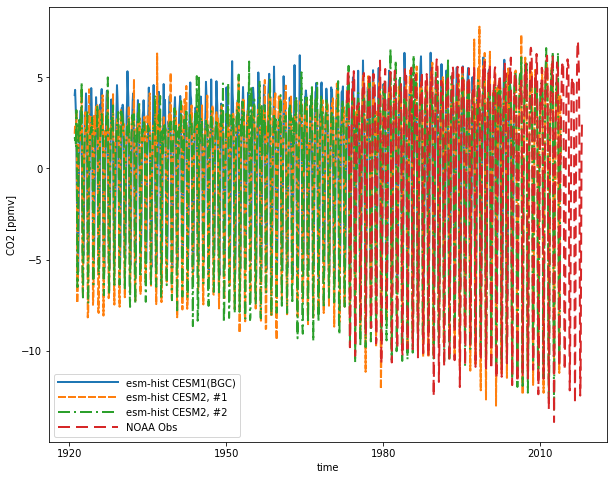

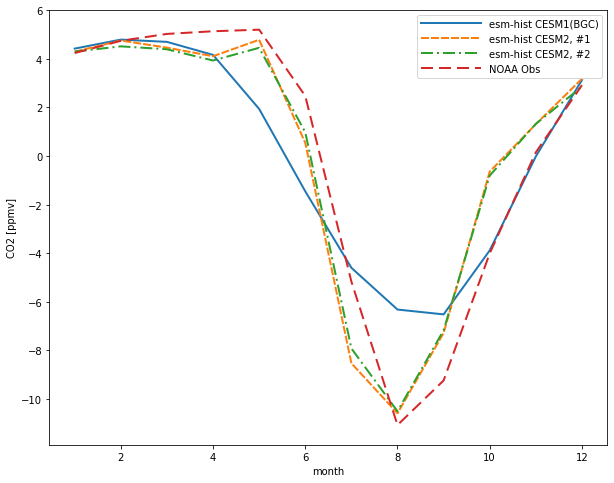

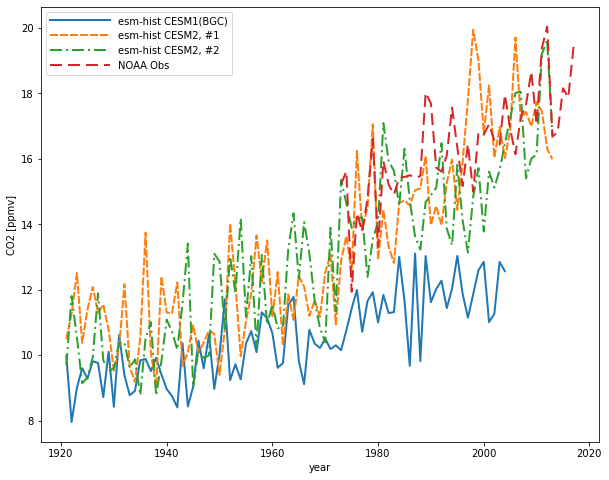

2020-03-02 19:47:56.287197(<module>):loading model output for esm-hist-cmip5 at mlo
2020-03-02 19:48:14.850608(<module>):loaded
2020-03-02 19:48:14.871760(<module>):loading model output for esm-hist at mlo
2020-03-02 19:49:33.702343(<module>):loaded
samples = 1032
year_span = 1920.0-2006.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 504
year_span = 1977.0-2019.0
samples per year = 12.0
****************************************


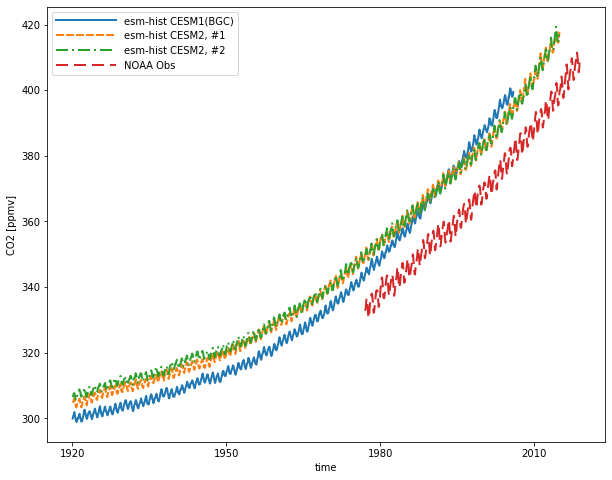

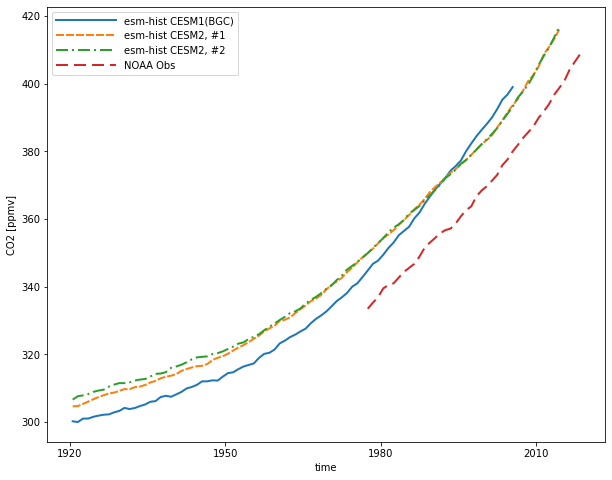

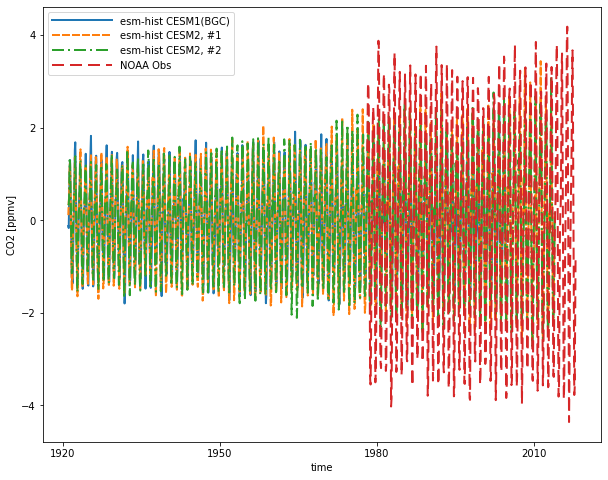

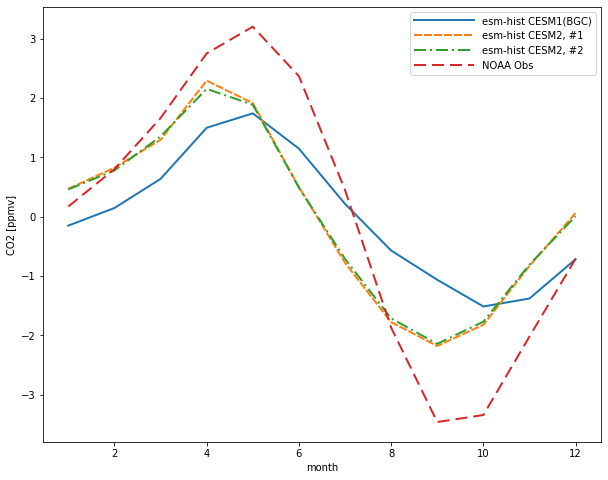

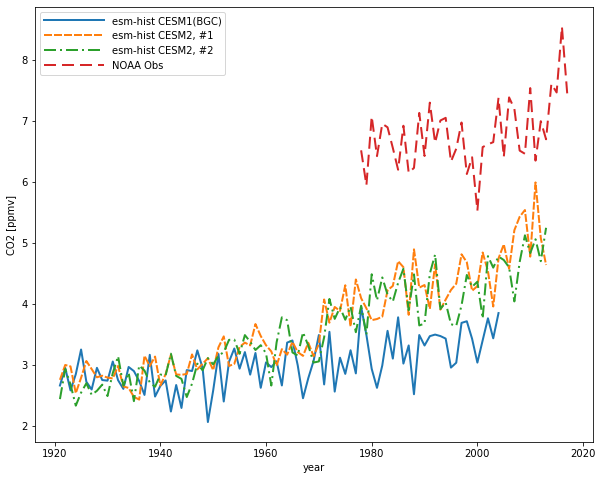

In [5]:
for site, site_metadata in site_metadata_dict.items():
    ds_list = []
    year_span = site_metadata["year_span"]
    time_sel = slice("1920-01-01", "2015-01-01")
    seldict = {"lat": site_metadata["lat"], "lon": site_metadata["lon"], "lev": site_metadata["press"]}
    for expr, ds in ds_dict.items():
        ds_sel = ds[["time_bnds", "CO2"]].sel(seldict, method="nearest").sel(time=time_sel)
        print_timestamp(f"loading model output for {expr} at {site}")
        ds_sel.load()
        print_timestamp(f"loaded")
        if "unit_conv" in var_spec:
            ds_sel[varname].attrs["units"] = f"({var_spec['unit_conv']})({ds_sel[varname].attrs['units']})"
        if "display_units" in var_spec:
            ds_sel[varname] = conv_units(ds_sel[varname], var_spec["display_units"])
        if "ensemble" in ds_sel.dims:
            for ensemble in range(ds.sizes["ensemble"]):
                ds_list.append(ds_sel.isel(ensemble=ensemble))
        else:
            ds_list.append(ds_sel)
    ds_list.append(ds_obs[site])
    legend_list = ["esm-hist CESM1(BGC)", "esm-hist CESM2, #1", "esm-hist CESM2, #2", "NOAA Obs"]
    dataset_summary(ds_list, legend_list)

2020-03-02 20:11:15.920402(<module>):loading model output for esm-hist-cmip5 at brw
2020-03-02 20:11:32.773525(<module>):loaded
2020-03-02 20:11:32.793900(<module>):loading model output for esm-hist at brw
2020-03-02 20:12:51.542732(<module>):loaded
samples = 1032
year_span = 1920.0-2006.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 564
year_span = 1972.0-2019.0
samples per year = 12.0
****************************************


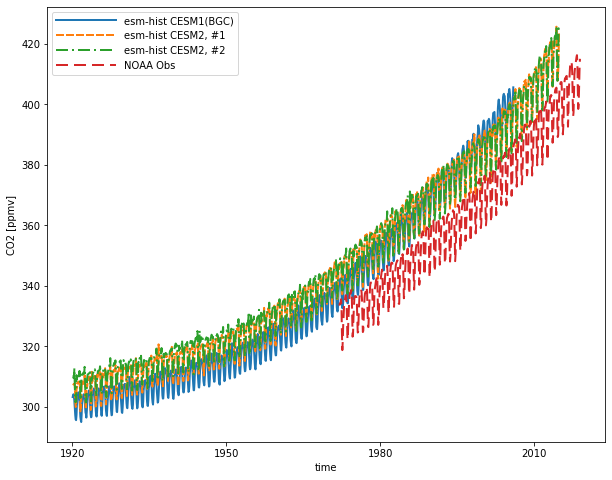

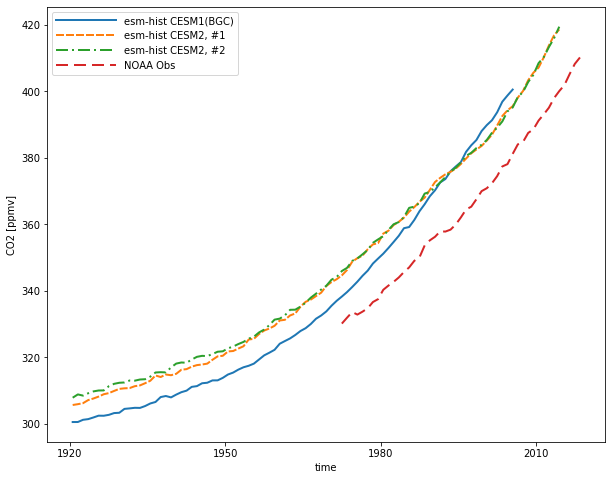

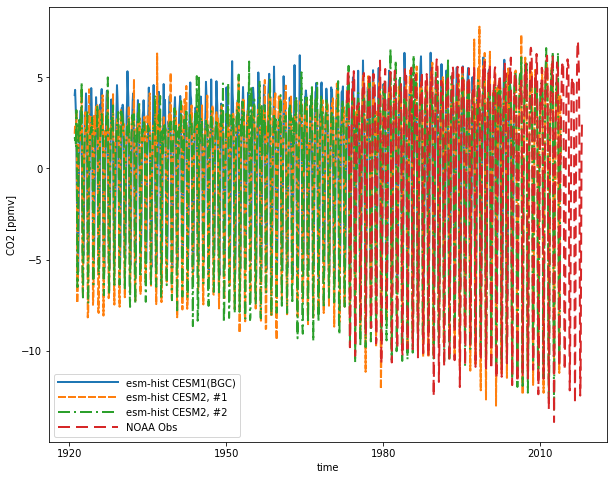

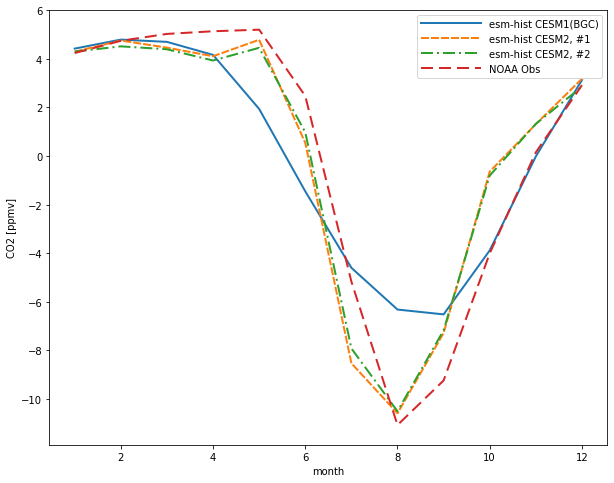

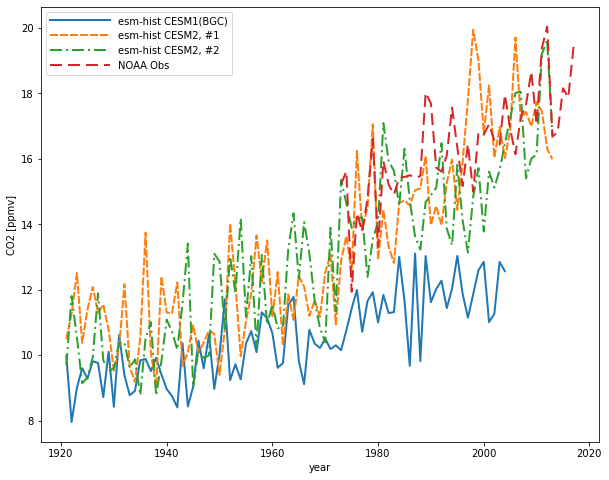

2020-03-02 20:12:57.415723(<module>):loading model output for esm-hist-cmip5 at mlo
2020-03-02 20:13:14.455907(<module>):loaded
2020-03-02 20:13:14.476903(<module>):loading model output for esm-hist at mlo
2020-03-02 20:14:33.340736(<module>):loaded
samples = 1032
year_span = 1920.0-2006.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 1140
year_span = 1920.0-2015.0
samples per year = 12.0
****************************************
samples = 504
year_span = 1977.0-2019.0
samples per year = 12.0
****************************************


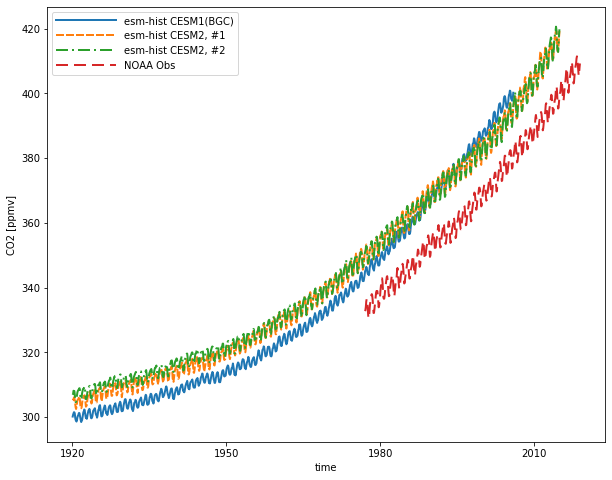

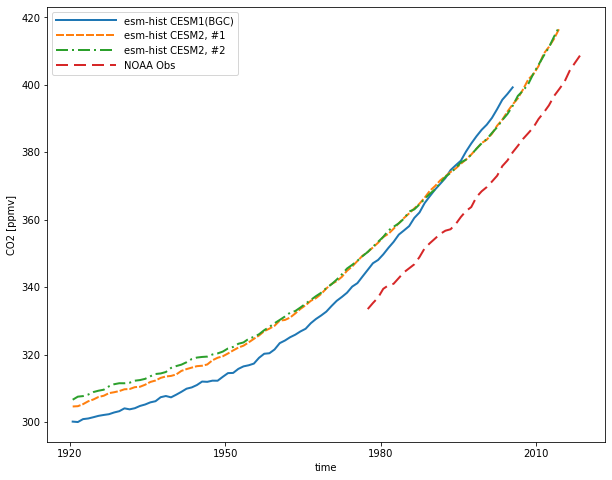

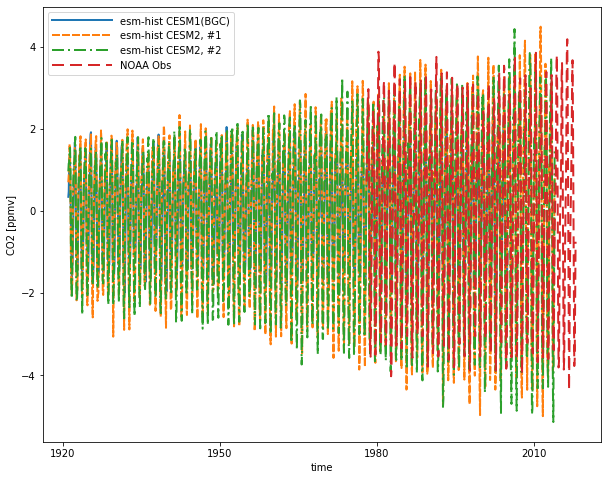

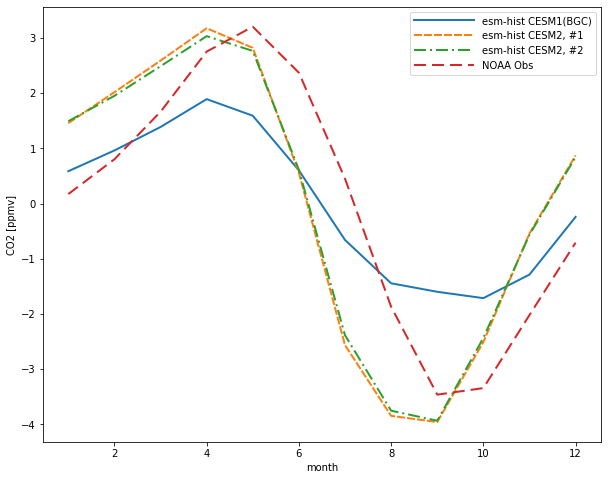

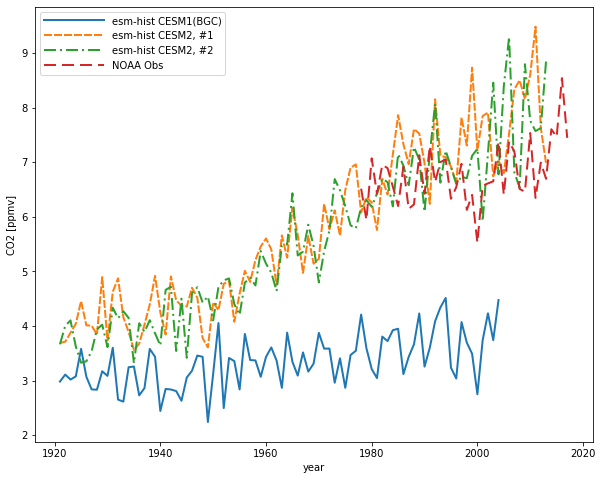

In [6]:
for site, site_metadata in site_metadata_dict.items():
    ds_list = []
    year_span = site_metadata["year_span"]
    time_sel = slice("1920-01-01", "2015-01-01")
    seldict = {"lat": site_metadata["lat"], "lon": site_metadata["lon"], "lev": 1000.0}
    for expr, ds in ds_dict.items():
        ds_sel = ds[["time_bnds", "CO2"]].sel(seldict, method="nearest").sel(time=time_sel)
        print_timestamp(f"loading model output for {expr} at {site}")
        ds_sel.load()
        print_timestamp(f"loaded")
        if "unit_conv" in var_spec:
            ds_sel[varname].attrs["units"] = f"({var_spec['unit_conv']})({ds_sel[varname].attrs['units']})"
        if "display_units" in var_spec:
            ds_sel[varname] = conv_units(ds_sel[varname], var_spec["display_units"])
        if "ensemble" in ds_sel.dims:
            for ensemble in range(ds.sizes["ensemble"]):
                ds_list.append(ds_sel.isel(ensemble=ensemble))
        else:
            ds_list.append(ds_sel)
    ds_list.append(ds_obs[site])
    legend_list = ["esm-hist CESM1(BGC)", "esm-hist CESM2, #1", "esm-hist CESM2, #2", "NOAA Obs"]
    dataset_summary(ds_list, legend_list)